In [1]:
import random
import pandas as pd
from binarytree import Node, build
import numpy as np
import scipy as sp
import chart_studio.plotly as py
import plotly.graph_objects as go
from ipywidgets import widgets

LogosBFT works by partitioning the nodes into equally-sized committees, then forming a binary tree structure from those committees. A primary (or leader) then partitions the propposed data to be verified via erasure coding techniques (fountain or raptor codes) and distributes it through the tree.

This notebook is an attempt to simulate various structures and their respective consequences w.r.t. bandwidth, byzantine behavior, latency, etc. 

The general process can be described by the following:
- Get Random Seed (Blackboxed here)
- Form Overlay
    - Initial Committee Assignment
    - Overlay Tree Structure Formation
    - Parent <--> Child Assignment
- Leader Selection (Blackboxed here)
- Leader Forms Block Proposal (Blackboxed here)
- Proposal Erasure Coding
- Data Dissemination
- Each Committee Forms Block Independently

We'd like to track the following metrics:
- total bandwidth for an individual node
- total num of messages for an individual node
- latency of block distribution throughout the network

## Globals definitions

In [2]:
num_nodes = 1550
committee_size = 50
num_committees = num_nodes / committee_size
byzantine_coeff = 0.15
max_time_delay = 60 # seconds
block_size = 1 # MB

# Form overlay



## Initial Committee Assignment

In [3]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

random_node_list = [i for i in range(num_nodes)]
random.shuffle(random_node_list)

committee_list = list(chunks(random_node_list, committee_size))

In [4]:
# Create DataFrame of committee assignments and their index
committee_df = pd.DataFrame(
    [{"committee_ind": ind, 
      "committee_members": committee}
     for ind, committee in enumerate(committee_list)])
committee_df["isChild"] = [row['committee_ind'] != 0 for ind, row in committee_df.iterrows()]
committee_df["isParent"] = [row['committee_ind'] != num_committees -1 for ind, row in committee_df.iterrows()]
committee_df.head()

,committee_ind,committee_members,isChild,isParent
0,0,"[91, 776, 453, 1297, 479, 1398, 108, 286, 323,...",False,True
1,1,"[402, 900, 1244, 334, 1286, 658, 1442, 529, 29...",True,True
2,2,"[1478, 1250, 533, 474, 868, 940, 599, 677, 135...",True,True
3,3,"[855, 1454, 109, 1282, 1133, 1482, 1508, 1174,...",True,True
4,4,"[996, 1536, 897, 903, 552, 902, 789, 1201, 125...",True,True


In [5]:
# Sanity check that all buckets are the same (or close) in size
for committee in committee_df["committee_members"].values:
    print(len(committee))

50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50


## Form Overlay Tree Structure

In [6]:
committee_list = [int(value) for value in committee_df['committee_ind'].values]

In [7]:
overlay = build(committee_list)

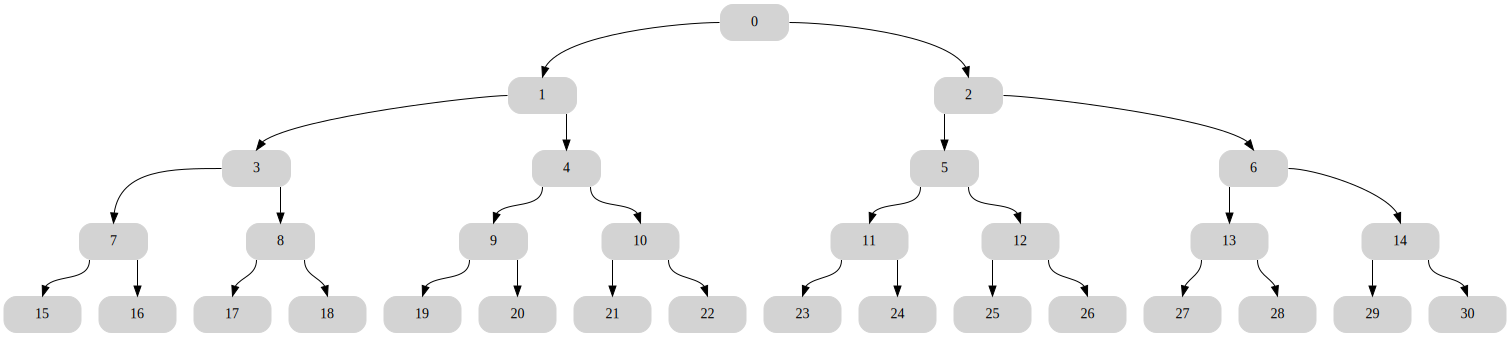

In [8]:
overlay.graphviz()

In [9]:
overlay.levels

[[Node(0)],
 [Node(1), Node(2)],
 [Node(3), Node(4), Node(5), Node(6)],
 [Node(7), Node(8), Node(9), Node(10), Node(11), Node(12), Node(13), Node(14)],
 [Node(15),
  Node(16),
  Node(17),
  Node(18),
  Node(19),
  Node(20),
  Node(21),
  Node(22),
  Node(23),
  Node(24),
  Node(25),
  Node(26),
  Node(27),
  Node(28),
  Node(29),
  Node(30)]]

## Parent <> Child Assignment

In [10]:
parent_child_map = []
for node in overlay:
    # Is this node a Parent?
    if committee_df.iloc[node.value,3]:
        rand_parent_list = list(committee_df.iloc[node.value,:]["committee_members"])
        random.shuffle(rand_parent_list)
        if node.left != None:
            rand_left_list = list(committee_df.iloc[node.left.value,:]["committee_members"])
            random.shuffle(rand_left_list)
        if node.right != None:
            rand_right_list = list(committee_df.iloc[node.right.value,:]["committee_members"])
            random.shuffle(rand_right_list)
    for p,c1,c2 in zip(rand_parent_list, rand_left_list, rand_right_list):
        parent_child_map.append({"parent": p, "children": [c1, c2]})
parent_child_df = pd.DataFrame(parent_child_map)
parent_child_df.head()

,parent,children
0,231,"[1486, 170]"
1,400,"[47, 474]"
2,1533,"[1286, 99]"
3,1015,"[529, 1292]"
4,34,"[711, 1250]"


In [11]:
def get_committee_ind(node_ind):
    for ind, committee in committee_df.iterrows():
        if node_ind in committee["committee_members"]:
            return ind

In [12]:
parent_child_df["committee_ind"] = parent_child_df["parent"].apply(get_committee_ind)

In [13]:
parent_child_df

,parent,children,committee_ind
0,231,"[1486, 170]",0
1,400,"[47, 474]",0
2,1533,"[1286, 99]",0
3,1015,"[529, 1292]",0
4,34,"[711, 1250]",0
...,...,...,...
1545,384,"[1009, 528]",29
1546,1157,"[305, 1245]",29
1547,647,"[1487, 985]",29
1548,844,"[1404, 1068]",29


## Erasure Code a Block

In [14]:
# Currently these are made up, research reasonable values
num_slices = 100 
num_codes = 100
total_chunks = num_slices + num_codes
size_per_chunk = block_size / (num_codes + num_slices) # MB
redundancy_factor = 1.5
num_blocks_per_committee_member = redundancy_factor * total_chunks / committee_size
min_num_messages_to_reconstruct = num_slices - num_blocks_per_committee_member

In [15]:
num_blocks_per_committee_member

6.0

In [16]:
size_per_chunk

0.005

## Dashboard

In [17]:
num_nodes = widgets.IntSlider(
    value = 1550,
    min = 100,
    max = 100000,
    step = 50,
    description = "Number of Nodes:",
    continuos_update=True
)

committee_size = widgets.IntSlider(
    value = 50,
    min = 20,
    max = 500,
    step = 5,
    description = "Size of a Committee:",
    continuos_update=True
)

byzantine_perc = widgets.IntSlider(
    value = 0.15,
    min = 0,
    max = 1,
    step = .01,
    description = "Byzantine Percentage:",
    continuos_update=True
)

block_size = widgets.IntSlider(
    value = 1,
    min = 1,
    max = 100,
    step = 1,
    description = "Block Size:",
    continuos_update=True
)

container = widgets.HBox(children=[num_nodes, committee_size, byzantine_perc, block_size])

AttributeError: type object 'DOMWidget' has no attribute '_ipython_display_'

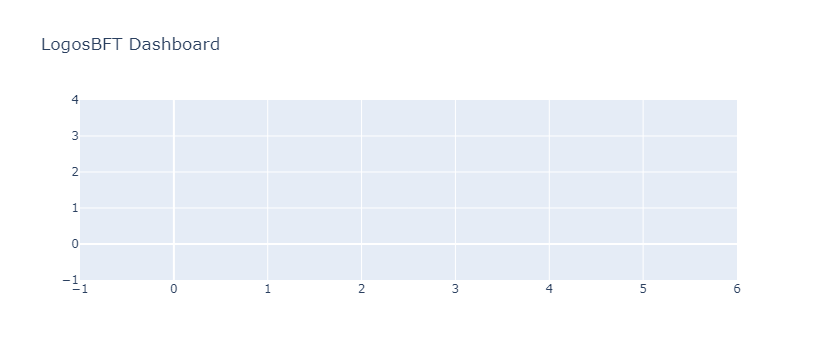

In [19]:
g = go.FigureWidget(data=[],
                    layout=go.Layout(
                        title = dict(
                            text="LogosBFT Dashboard"
                        ),
                        barmode="overlay"
                    ))
g.add_annotation(x=2, y=5,
                       text="sample text"
                      )

In [ ]:
widgets.VBox([container, g])